In [1]:
import pandas as pd
import numpy as np
# mta_df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_210605.txt')
# mta_df.to_csv('mta_turnstile_210605.csv', header=False, index=False)

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" #url with formatting to fill in the number of the particular week
    dfs = []
    for week_num in week_nums: 
        file_url = url.format(week_num) 
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs) #combine files for each week
weeks = [210605, 210612, 210619, 210626, 210703, 210710, 210717, 210724, 210731, 210807, 210814, 210821, 210828]
# turnstiles_df = get_data(weeks)
# turnstiles_df.to_csv('mta_data_all.csv', header = False, index = False) #Imports all data to a csv that can be read by SQL

In [3]:
from sqlalchemy import create_engine
import pandas as pd
engine = create_engine("sqlite:///mta_all.db")
all_data = pd.read_sql('SELECT * FROM mta_data;', engine)
station_count= pd.read_sql('SELECT COUNT(DISTINCT STATION) FROM mta_data;', engine)
line_count_grand_cntrl = pd.read_sql('SELECT COUNT(DISTINCT LINENAME) as line_count, STATION, CA FROM mta_data WHERE STATION LIKE "GRD%" GROUP BY STATION, CA ORDER BY 1 DESC, 2;', engine)
line_count_grand_cntrl
ca_count = pd.read_sql('SELECT COUNT(DISTINCT CA) as CA_count, STATION FROM mta_data WHERE STATION in ("34 ST-HERALD SQ", "GRD CNTRL-42 ST", "FLUSHING-MAIN", "42 ST-PORT AUTH", "34 ST-PENN STA") GROUP BY STATION HAVING CA_count > 1 ORDER BY 1 DESC, 2;', engine)
ca_count

,CA_count,STATION
0,13,34 ST-PENN STA
1,8,GRD CNTRL-42 ST
2,5,34 ST-HERALD SQ
3,5,42 ST-PORT AUTH
4,2,FLUSHING-MAIN


In [4]:
ts_df1 = all_data
ts_df1.sample(20)
station_count

,COUNT(DISTINCT STATION)
0,379


In [5]:
import datetime as dt
ts_df1['Date_time'] = pd.to_datetime(ts_df1.DATE.astype(str) + ' ' + ts_df1.TIME.astype(str))
# ts_df1.head(5)

In [6]:
ts_df1.groupby(['CA', 'UNIT', 'SCP', 'STATION', 'Date_time']).ENTRIES.count().reset_index().sort_values('ENTRIES', ascending=False).head(5)

,CA,UNIT,SCP,STATION,Date_time,ENTRIES
2448636,R514,R094,00-05-00,ASTORIA BLVD,2021-07-22 04:00:00,2
1172385,N335,R158,01-00-03,KEW GARDENS,2021-06-20 18:30:00,2
2457222,R516,R291,00-00-02,33 ST-RAWSON ST,2021-08-25 00:00:00,2
2457223,R516,R291,00-00-02,33 ST-RAWSON ST,2021-08-25 04:00:00,2
2457224,R516,R291,00-00-02,33 ST-RAWSON ST,2021-08-25 08:00:00,2


In [7]:
ts_df1.sort_values(['CA', 'UNIT', 'SCP', 'STATION', 'Date_time'], inplace=True, ascending=False)
ts_df1.drop_duplicates(subset=['CA', 'UNIT', 'SCP', 'STATION', 'Date_time'], inplace=True)


In [8]:
ts_df1.groupby(['CA', 'UNIT', 'SCP', 'STATION', 'Date_time']).EXITS.count().reset_index().sort_values('EXITS', ascending=False).head(5)

,CA,UNIT,SCP,STATION,Date_time,EXITS
0,A002,R051,02-00-00,59 ST,2021-05-29 00:00:00,1
1815048,R138,R293,00-03-02,34 ST-PENN STA,2021-07-22 18:00:00,1
1815050,R138,R293,00-03-02,34 ST-PENN STA,2021-07-23 02:00:00,1
1815051,R138,R293,00-03-02,34 ST-PENN STA,2021-07-23 06:00:00,1
1815052,R138,R293,00-03-02,34 ST-PENN STA,2021-07-23 10:00:00,1


In [9]:
ts_entries_daily = (ts_df1.groupby(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE'], as_index=False).ENTRIES.max())

In [10]:
ts_entries_daily.head()

,CA,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,05/29/2021,7579021
1,A002,R051,02-00-00,59 ST,NQR456W,05/30/2021,7579275
2,A002,R051,02-00-00,59 ST,NQR456W,05/31/2021,7579593
3,A002,R051,02-00-00,59 ST,NQR456W,06/01/2021,7580178
4,A002,R051,02-00-00,59 ST,NQR456W,06/02/2021,7580754


In [11]:
ts_entries_daily[['PREV_DATE', 'PREV_ENTRIES']] = (ts_entries_daily.groupby(["CA", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]].shift(1))

In [12]:
ts_entries_daily.dropna(subset=['PREV_DATE'], axis=0, inplace=True)

In [13]:
ts_entries_daily

,CA,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,05/30/2021,7579275,05/29/2021,7579021.0
2,A002,R051,02-00-00,59 ST,NQR456W,05/31/2021,7579593,05/30/2021,7579275.0
3,A002,R051,02-00-00,59 ST,NQR456W,06/01/2021,7580178,05/31/2021,7579593.0
4,A002,R051,02-00-00,59 ST,NQR456W,06/02/2021,7580754,06/01/2021,7580178.0
5,A002,R051,02-00-00,59 ST,NQR456W,06/03/2021,7581328,06/02/2021,7580754.0
...,...,...,...,...,...,...,...,...,...
454566,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,08/23/2021,5554,08/22/2021,5554.0
454567,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,08/24/2021,5554,08/23/2021,5554.0
454568,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,08/25/2021,5554,08/24/2021,5554.0
454569,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,08/26/2021,5554,08/25/2021,5554.0


In [14]:
(ts_entries_daily["ENTRIES"] - ts_entries_daily["PREV_ENTRIES"]).describe()

count    4.495520e+05
mean    -6.139827e+03
std      2.926490e+06
min     -1.383110e+09
25%      8.200000e+01
50%      2.640000e+02
75%      5.220000e+02
max      6.684993e+08
dtype: float64

In [15]:
ts_entries_daily[ts_entries_daily['ENTRIES'] < ts_entries_daily['PREV_ENTRIES']].head(5)

,CA,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3550,A011,R080,01-03-00,57 ST-7 AV,NQRW,05/30/2021,885601566,05/29/2021,885601748.0
3551,A011,R080,01-03-00,57 ST-7 AV,NQRW,05/31/2021,885601403,05/30/2021,885601566.0
3552,A011,R080,01-03-00,57 ST-7 AV,NQRW,06/01/2021,885601292,05/31/2021,885601403.0
3553,A011,R080,01-03-00,57 ST-7 AV,NQRW,06/02/2021,885601049,06/01/2021,885601292.0
3554,A011,R080,01-03-00,57 ST-7 AV,NQRW,06/03/2021,885600810,06/02/2021,885601049.0


In [16]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
#         print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

ts_entries_daily["DAILY_ENTRIES"] = ts_entries_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [17]:
ts_entries_daily.sample(20)

,CA,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
22013,A053,R088,03-00-01,CORTLANDT ST,RNW,08/21/2021,174508,08/20/2021,174477.0,31.0
216605,N504,R021,02-00-02,42 ST-BRYANT PK,BDFM7,08/08/2021,10172561,08/07/2021,10172362.0,199.0
118569,N063,R011,02-03-00,42 ST-PORT AUTH,ACENQRS1237W,07/19/2021,9036769,07/18/2021,9035649.0,1120.0
298293,R127,R105,00-06-00,14 ST,123FLM,06/09/2021,142120057,06/08/2021,142119196.0,861.0
137386,N095A,R014,01-03-00,FULTON ST,2345ACJZ,06/29/2021,2633301,06/28/2021,2632590.0,711.0
39104,B024A,R211,02-00-03,KINGS HWY,BQ,08/13/2021,1854830,08/12/2021,1854318.0,512.0
210894,N420B,R317,00-03-00,CLINTON-WASH AV,G,08/26/2021,383883,08/25/2021,383870.0,13.0
244152,N601A,R319,01-03-03,LEXINGTON AV/63,F,07/30/2021,58505,07/29/2021,57646.0,859.0
2085,A007,R079,01-06-00,5 AV/59 ST,NQRW,08/20/2021,757047,08/19/2021,756854.0,193.0
203207,N400A,R359,02-00-05,COURT SQ,EMG,07/14/2021,114189,07/13/2021,113754.0,435.0


In [18]:
ts_exits_daily = ts_df1.groupby(['CA', 'UNIT', 'SCP', 'STATION', 'DATE', 'LINENAME'], as_index=False).EXITS.max()

In [19]:
ts_exits_daily

,CA,UNIT,SCP,STATION,DATE,LINENAME,EXITS
0,A002,R051,02-00-00,59 ST,05/29/2021,NQR456W,2590439
1,A002,R051,02-00-00,59 ST,05/30/2021,NQR456W,2590548
2,A002,R051,02-00-00,59 ST,05/31/2021,NQR456W,2590641
3,A002,R051,02-00-00,59 ST,06/01/2021,NQR456W,2590917
4,A002,R051,02-00-00,59 ST,06/02/2021,NQR456W,2591200
...,...,...,...,...,...,...,...
454566,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/23/2021,R,614
454567,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/24/2021,R,614
454568,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/25/2021,R,614
454569,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/26/2021,R,614


In [20]:
ts_exits_daily[['PREV_DATE', 'PREV_EXIT']] = (ts_exits_daily.groupby(['CA', 'UNIT', 'SCP', 'STATION'])[['DATE', 'EXITS']].shift(1))

In [21]:
ts_exits_daily.dropna(subset=['PREV_DATE'], axis=0, inplace=True)

In [22]:
ts_exits_daily

,CA,UNIT,SCP,STATION,DATE,LINENAME,EXITS,PREV_DATE,PREV_EXIT
1,A002,R051,02-00-00,59 ST,05/30/2021,NQR456W,2590548,05/29/2021,2590439.0
2,A002,R051,02-00-00,59 ST,05/31/2021,NQR456W,2590641,05/30/2021,2590548.0
3,A002,R051,02-00-00,59 ST,06/01/2021,NQR456W,2590917,05/31/2021,2590641.0
4,A002,R051,02-00-00,59 ST,06/02/2021,NQR456W,2591200,06/01/2021,2590917.0
5,A002,R051,02-00-00,59 ST,06/03/2021,NQR456W,2591445,06/02/2021,2591200.0
...,...,...,...,...,...,...,...,...,...
454566,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/23/2021,R,614,08/22/2021,613.0
454567,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/24/2021,R,614,08/23/2021,614.0
454568,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/25/2021,R,614,08/24/2021,614.0
454569,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/26/2021,R,614,08/25/2021,614.0


In [23]:
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXIT"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
#         print(f'exits: {row["EXITS"]} <-- {row["PREV_EXIT"]}')
        
        counter = min(row["EXITS"], row["PREV_EXIT"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

ts_exits_daily["DAILY_EXITS"] = ts_exits_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [24]:
ts_exits_daily.DAILY_EXITS.describe()
IQR = ts_exits_daily.DAILY_EXITS.describe().loc['75%']-ts_exits_daily.DAILY_EXITS.describe().loc['25%']
IQR
ts_exits_daily.DAILY_EXITS.describe()

count    449552.000000
mean        469.174064
std        4519.372045
min           0.000000
25%          83.000000
50%         262.000000
75%         585.000000
max      981271.000000
Name: DAILY_EXITS, dtype: float64

In [25]:
max_thresh = ts_exits_daily.describe().loc['75%']['DAILY_EXITS'] + IQR*100
min_thresh = ts_exits_daily.describe().loc['25%']['DAILY_EXITS'] - IQR*100

In [26]:
ts_exits_daily = ts_exits_daily.drop(ts_exits_daily.index[ts_exits_daily['DAILY_EXITS'] <= min_thresh])
ts_exits_daily = ts_exits_daily.drop(ts_exits_daily.index[ts_exits_daily['DAILY_EXITS'] >= max_thresh])
ts_exits_daily.DAILY_EXITS.describe()

count    449472.000000
mean        421.593229
std         564.164333
min           0.000000
25%          83.000000
50%         262.000000
75%         584.000000
max       49265.000000
Name: DAILY_EXITS, dtype: float64

In [27]:
ca_unit_station_entries = ts_entries_daily.groupby(['CA', 'UNIT', 'STATION', 'DATE', 'LINENAME'])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_entries[ca_unit_station_entries['STATION']== '34 ST-HERALD SQ'].head(10)

,CA,UNIT,STATION,DATE,LINENAME,DAILY_ENTRIES
900,A022,R022,34 ST-HERALD SQ,05/30/2021,BDFMNQRW,2360.0
901,A022,R022,34 ST-HERALD SQ,05/31/2021,BDFMNQRW,2656.0
902,A022,R022,34 ST-HERALD SQ,06/01/2021,BDFMNQRW,4119.0
903,A022,R022,34 ST-HERALD SQ,06/02/2021,BDFMNQRW,4377.0
904,A022,R022,34 ST-HERALD SQ,06/03/2021,BDFMNQRW,4277.0
905,A022,R022,34 ST-HERALD SQ,06/04/2021,BDFMNQRW,3930.0
906,A022,R022,34 ST-HERALD SQ,06/05/2021,BDFMNQRW,3493.0
907,A022,R022,34 ST-HERALD SQ,06/06/2021,BDFMNQRW,2732.0
908,A022,R022,34 ST-HERALD SQ,06/07/2021,BDFMNQRW,4084.0
909,A022,R022,34 ST-HERALD SQ,06/08/2021,BDFMNQRW,4367.0


In [28]:
ca_unit_station_exits = ts_exits_daily.groupby(['CA', 'UNIT', 'STATION', 'DATE', 'LINENAME'])[['DAILY_EXITS']].sum().reset_index()
ca_unit_station_exits.head()

,CA,UNIT,STATION,DATE,LINENAME,DAILY_EXITS
0,A002,R051,59 ST,05/30/2021,NQR456W,1452.0
1,A002,R051,59 ST,05/31/2021,NQR456W,1846.0
2,A002,R051,59 ST,06/01/2021,NQR456W,3683.0
3,A002,R051,59 ST,06/02/2021,NQR456W,4080.0
4,A002,R051,59 ST,06/03/2021,NQR456W,3795.0


In [29]:
station_daily_entries = ts_entries_daily.groupby(['STATION', 'DATE', 'LINENAME'])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_entries.head()

,STATION,DATE,LINENAME,DAILY_ENTRIES
0,1 AV,05/30/2021,L,4575.0
1,1 AV,05/31/2021,L,4943.0
2,1 AV,06/01/2021,L,7487.0
3,1 AV,06/02/2021,L,7993.0
4,1 AV,06/03/2021,L,7844.0


In [30]:
station_daily_exits = ts_exits_daily.groupby(['STATION', 'DATE', 'LINENAME'])[['DAILY_EXITS']].sum().reset_index()
station_daily_exits[station_daily_exits['STATION']== '34 ST-HERALD SQ'].head(10)

,STATION,DATE,LINENAME,DAILY_EXITS
8006,34 ST-HERALD SQ,05/30/2021,BDFMNQRW,25655.0
8007,34 ST-HERALD SQ,05/31/2021,BDFMNQRW,29723.0
8008,34 ST-HERALD SQ,06/01/2021,BDFMNQRW,43843.0
8009,34 ST-HERALD SQ,06/02/2021,BDFMNQRW,47549.0
8010,34 ST-HERALD SQ,06/03/2021,BDFMNQRW,44746.0
8011,34 ST-HERALD SQ,06/04/2021,BDFMNQRW,44271.0
8012,34 ST-HERALD SQ,06/05/2021,BDFMNQRW,37356.0
8013,34 ST-HERALD SQ,06/06/2021,BDFMNQRW,30409.0
8014,34 ST-HERALD SQ,06/07/2021,BDFMNQRW,44750.0
8015,34 ST-HERALD SQ,06/08/2021,BDFMNQRW,47677.0


In [31]:
station_total_exits = station_daily_exits.groupby(['STATION', 'LINENAME'])['DAILY_EXITS'].sum().reset_index().sort_values('DAILY_EXITS', ascending=False)
station_total_exits.head(10)

,STATION,LINENAME,DAILY_EXITS
312,GRD CNTRL-42 ST,4567S,4033266.0
89,34 ST-HERALD SQ,BDFMNQRW,4032599.0
102,42 ST-PORT AUTH,ACENQRS1237W,2870229.0
93,34 ST-PENN STA,ACE,2789649.0
289,FLUSHING-MAIN,7,2412090.0
28,14 ST-UNION SQ,LNQR456W,2196294.0
448,TIMES SQ-42 ST,1237ACENQRSW,1884883.0
339,JKSN HT-ROOSVLT,EFMR7,1883865.0
156,86 ST,456,1855321.0
302,FULTON ST,2345ACJZ,1830166.0


In [32]:
station_total_entries = station_daily_entries.groupby(['STATION', 'LINENAME'])['DAILY_ENTRIES'].sum().reset_index().sort_values('DAILY_ENTRIES', ascending=False)
station_total_entries.head(10)

,STATION,LINENAME,DAILY_ENTRIES
89,34 ST-HERALD SQ,BDFMNQRW,3677527.0
404,PATH NEW WTC,1,3397612.0
312,GRD CNTRL-42 ST,4567S,2864685.0
102,42 ST-PORT AUTH,ACENQRS1237W,2410646.0
289,FLUSHING-MAIN,7,2084488.0
93,34 ST-PENN STA,ACE,2057637.0
339,JKSN HT-ROOSVLT,EFMR7,1968776.0
446,THIRTY THIRD ST,1,1912203.0
87,33 ST,6,1860717.0
302,FULTON ST,2345ACJZ,1823701.0


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

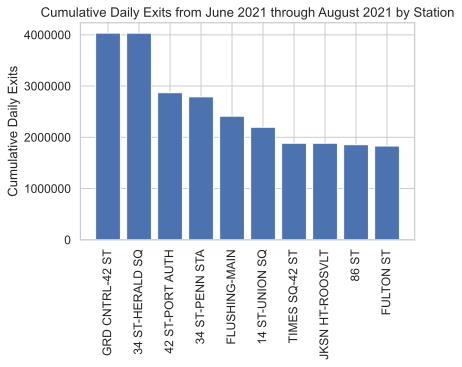

In [38]:
plt.bar(x=station_total_exits['STATION'][:10], height=station_total_exits['DAILY_EXITS'][:10])
plt.xticks(rotation=90)
plt.ylabel('Cumulative Daily Exits')
plt.title('Cumulative Daily Exits from June 2021 through August 2021 by Station')
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('figures/Cumulative_D_Exit.png', bbox_inches = 'tight')
plt.savefig('figures/Cumulative_D_Exit.svg', bbox_inches = 'tight')

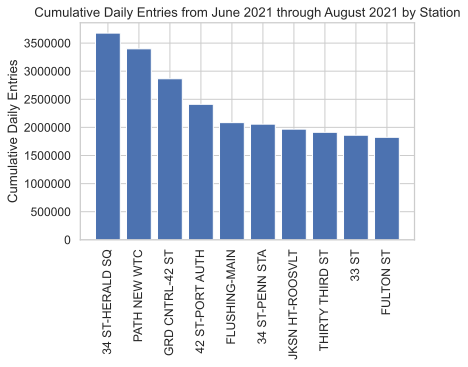

In [41]:
plt.bar(x=station_total_entries['STATION'][:10], height=station_total_entries['DAILY_ENTRIES'][:10])
plt.xticks(rotation=90)
plt.ylabel('Cumulative Daily Entries')
plt.title('Cumulative Daily Entries from June 2021 through August 2021 by Station')
plt.ticklabel_format(axis='y', style='plain')
plt.savefig('figures/Cumulative_D_Entry.png', bbox_inches = 'tight')

In [36]:
# todo: Create a chart looking at the highest traffic stations with the lines, as well as days and daily peak
station_daily_exits['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily_exits['DATE']).dt.dayofweek
station_daily_exits_avg = station_daily_exits.groupby(['STATION', 'DAY_OF_WEEK_NUM'])['DAILY_EXITS'].mean().reset_index()
station_daily_exits_avg

,STATION,DAY_OF_WEEK_NUM,DAILY_EXITS
0,1 AV,0,12385.461538
1,1 AV,1,13306.076923
2,1 AV,2,13707.615385
3,1 AV,3,14079.846154
4,1 AV,4,14614.384615
...,...,...,...
2648,ZEREGA AV,2,1402.538462
2649,ZEREGA AV,3,1398.153846
2650,ZEREGA AV,4,1349.692308
2651,ZEREGA AV,5,806.916667


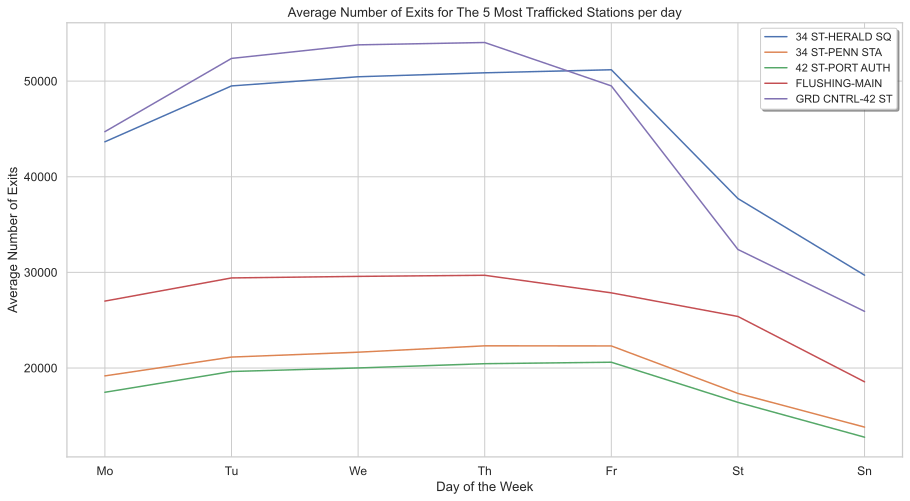

In [40]:
station_mask =((station_daily_exits_avg['STATION'] == '34 ST-HERALD SQ')|
               (station_daily_exits_avg['STATION'] == 'GRD CNTRL-42 ST')|
               (station_daily_exits_avg['STATION'] == 'FLUSHING-MAIN')|
               (station_daily_exits_avg['STATION'] == '42 ST-PORT AUTH')|
               (station_daily_exits_avg['STATION'] == '34 ST-PENN STA'))
station_day_exit_avg_top = station_daily_exits_avg[station_mask].reset_index()
station_day_exit_avg_top
plt.figure(figsize=(15,8)) 
for i, group in station_day_exit_avg_top.groupby('STATION'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_EXITS'], label = i)
plt.legend(shadow = True, loc = 0, fontsize = 'small')
plt.xlabel('Day of the Week');
plt.ylabel('Average Number of Exits');
plt.title('Average Number of Exits for The 5 Most Trafficked Stations per day')
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn']);

plt.savefig('figures/avg_exits_day_top5.jpeg', bbox_inches = 'tight')